In [1]:
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from onc import ONC
from onc.util import get_onc_token, dt2str

In [2]:
save_dir = '../data/hf'
onc = ONC(token = get_onc_token(),outPath = save_dir)

In [3]:
products = onc.getDataProducts({'locationCode': 'SOGCS', 'extension': 'nc'})
products

[{'dataProductCode': 'CODARQCSC',
  'dataProductName': 'CODAR Quality Controlled Surface Currents',
  'dataProductOptions': [{'allowableRange': None,
    'allowableValues': ['0', '1'],
    'defaultValue': '1',
    'documentation': ['https://wiki.oceannetworks.ca/pages/viewpage.action?pageId=81887426'],
    'option': 'dpo_IncludeRadials',
    'suboptions': None}],
  'extension': 'nc',
  'hasDeviceData': True,
  'hasPropertyData': False,
  'helpDocument': 'https://wiki.oceannetworks.ca/display/DP/148'}]

In [4]:
%%time
date_from = datetime(2016,3,30,0,0,0,0) # Start of the data request.
date_to = datetime(2016,3,30,11,59,59,999999) # End of the data request.

loc_code = 'SOGCS'
dev_cat_code = 'OCEANOGRAPHICRADAR'
data_product_code = 'CODARQCSC' # Quality Controlled Surface Currents
extension = 'nc'  # NetCDF output format.

params = {'locationCode': loc_code,
          'deviceCategoryCode': dev_cat_code,
          'dateFrom': dt2str(date_from),
          'dateTo': dt2str(date_to),
          'extension': extension,
          'dataProductCode': data_product_code}

req = onc.requestDataProduct(filters = params)
status = onc.runDataProduct(req['dpRequestId'])
for run_id in status['runIds']:
    down = onc.downloadDataProduct(run_id)

Request Id: 27101716
Estimated File Size: 433 kB
Estimated Processing Time: 45 s
To cancel the running data product, run 'onc.cancelDataProduct(27101716)'

   queued
   data product running...............
   1 files generated for this data product
   metadata product running
   complete


   Search complete, waiting on the file system to synchronize (StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20160330T000000.000Z_20160330T110000.000Z-Totals_Clean.nc).........................CPU times: total: 10.3 s
Wall time: 1min 1s


In [5]:
fp = '../data/hf/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20160330T000000.000Z_20160330T110000.000Z-Totals_Clean.nc'
ds = xr.open_dataset(fp)

ds = ds.sel(time = datetime(2016,3,30,11), method = 'nearest') # Select a single pass timestamp.

ds['spd'] = np.sqrt(ds.u**2 + ds.v**2)  # Calculate speed for colormap.

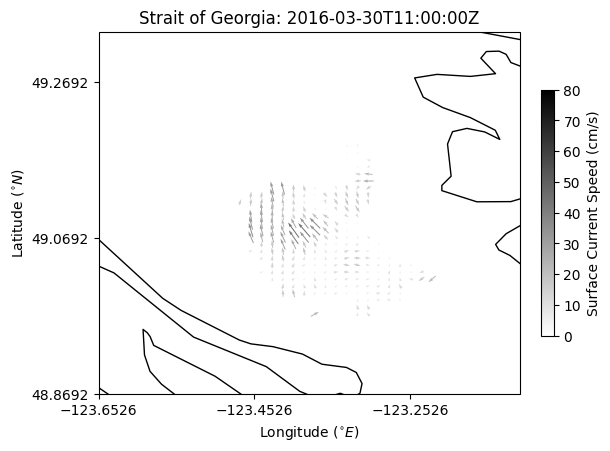

In [6]:
hfcmap = matplotlib.colormaps.get_cmap('gist_yarg')
hfnorm = matplotlib.colors.Normalize(vmin = 0 , vmax = 80) 

xmin = ds.lon.min()-0.03
xmax = ds.lon.max()+0.03
ymin = ds.lat.min()-0.03
ymax = ds.lat.max()+0.03
x_major_locator = 0.2
y_major_locator = 0.2

fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True, subplot_kw = {'projection': ccrs.PlateCarree()})
ax.set_extent([xmin, xmax, ymin, ymax])
ax.coastlines(zorder = 0)

ax.set_xticks(np.arange(xmin, xmax,x_major_locator))
ax.set_xlabel(r'Longitude ($^{\circ}E$)')

ax.set_yticks(np.arange(ymin, ymax,y_major_locator))
ax.set_ylabel(r'Latitude ($^{\circ}N$)')

ax.set_title('Strait of Georgia: ' + str(ds.time.min().values)[:-10] + 'Z')


quiv = ax.quiver(ds.lon, ds.lat, ds.u, ds.v, ds.spd, angles = 'uv', pivot = 'mid', cmap = hfcmap, norm = hfnorm)
fig.colorbar(quiv, ax = ax, shrink = 0.5, label = 'Surface Current Speed (cm/s)')
